# Car Price prediction

<img src="https://whatcar.vn/media/2018/09/car-lot-940x470.jpg"/>

## Прогнозирование стоимости автомобиля по характеристикам

## В ноутбуке мы сделаем следующее:
* Построим "наивную"/baseline модель, предсказывающую цену по модели и году выпуска (с ней будем сравнивать другие модели)
* Обработаем и отнормируем признаки
* Сделаем первую модель на основе градиентного бустинга с помощью CatBoost
* Сделаем вторую модель на основе нейронных сетей и сравним результаты
* Сделаем multi-input нейронную сеть для анализа табличных данных и текста одновременно
* Добавим в multi-input сеть обработку изображений
* Осуществим ансамблирование градиентного бустинга и нейронной сети (усреднение их предсказаний)

In [1]:
!pip install -q tensorflow==2.3

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [2]:
#аугментации изображений
!pip install albumentations -q

You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [3]:
!pip install pymorphy2
!pip install pymorphy2-dicts

     |████████████████████████████████| 55 kB 539 kB/s 
     |████████████████████████████████| 8.2 MB 4.0 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 7.1 MB 5.5 MB/s 
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.


In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import sys
import PIL
import cv2
import re

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# # keras
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras import optimizers
import albumentations
import pymorphy2

# plt
import matplotlib.pyplot as plt
#увеличим дефолтный размер графиков
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
#графики в svg выглядят более четкими
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)

Python       : 3.7.6 | packaged by conda-forge | (default, Mar 23 2020, 23:03:20) 
Numpy        : 1.18.5
Tensorflow   : 2.3.0


In [6]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

In [7]:
# всегда фиксируйте RANDOM_SEED, чтобы ваши эксперименты были воспроизводимы!
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

In [8]:
!pip freeze > requirements.txt

# DATA

Посмотрим на типы признаков:

* bodyType - категориальный
* brand - категориальный
* color - категориальный
* description - текстовый
* engineDisplacement - числовой, представленный как текст
* enginePower - числовой, представленный как текст
* fuelType - категориальный
* mileage - числовой
* modelDate - числовой
* model_info - категориальный
* name - категориальный, желательно сократить размерность
* numberOfDoors - категориальный
* price - числовой, **целевой**
* productionDate - числовой
* sell_id - изображение (файл доступен по адресу, основанному на sell_id)
* vehicleConfiguration - не используется (комбинация других столбцов)
* vehicleTransmission - категориальный
* Владельцы - категориальный
* Владение - числовой, представленный как текст
* ПТС - категориальный
* Привод - категориальный
* Руль - категориальный

In [9]:
DATA_DIR = '../input/sf-dst-car-price-prediction-part2/'
train = pd.read_csv(DATA_DIR + 'train.csv')
test = pd.read_csv(DATA_DIR + 'test.csv')
sample_submission = pd.read_csv(DATA_DIR + 'sample_submission.csv')

In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6682 entries, 0 to 6681
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bodyType              6682 non-null   object 
 1   brand                 6682 non-null   object 
 2   color                 6682 non-null   object 
 3   description           6682 non-null   object 
 4   engineDisplacement    6682 non-null   object 
 5   enginePower           6682 non-null   object 
 6   fuelType              6682 non-null   object 
 7   mileage               6682 non-null   int64  
 8   modelDate             6682 non-null   int64  
 9   model_info            6682 non-null   object 
 10  name                  6682 non-null   object 
 11  numberOfDoors         6682 non-null   int64  
 12  price                 6682 non-null   float64
 13  productionDate        6682 non-null   int64  
 14  sell_id               6682 non-null   int64  
 15  vehicleConfiguration 

In [11]:
train.nunique()

bodyType                  17
brand                      3
color                     16
description             6147
engineDisplacement        48
enginePower              146
fuelType                   4
mileage                 2900
modelDate                 41
model_info               118
name                     900
numberOfDoors              4
price                   1628
productionDate            38
sell_id                 6682
vehicleConfiguration     288
vehicleTransmission        4
Владельцы                  3
Владение                 173
ПТС                        2
Привод                     3
Руль                       2
dtype: int64

In [12]:
train.head()

,bodyType,brand,color,description,engineDisplacement,enginePower,fuelType,mileage,modelDate,model_info,...,price,productionDate,sell_id,vehicleConfiguration,vehicleTransmission,Владельцы,Владение,ПТС,Привод,Руль
0,седан,BMW,чёрный,Авто на бодром ходу. Все работает отлично. П...,3.0 LTR,272 N12,бензин,245000,2007,5ER,...,599000.0,2007,1099980990,SEDAN AUTOMATIC 3.0,автоматическая,3 или более,NaN,Оригинал,полный,Левый
1,седан,AUDI,серебристый,"Продажа от собственника, второй владелец, ПТС ...",2.8 LTR,204 N12,бензин,183000,2011,A6,...,850000.0,2011,1095836906,SEDAN VARIATOR 2.8,вариатор,2 владельца,8 лет и 6 месяцев,Оригинал,передний,Левый
2,седан,MERCEDES,чёрный,Внимание! Только для клиентов AVILON Автомобил...,3.5 LTR,306 N12,бензин,122733,2009,E_KLASSE,...,1325000.0,2013,1100195530,SEDAN AUTOMATIC 3.5,автоматическая,3 или более,NaN,Оригинал,полный,Левый
3,седан,AUDI,белый,В комплекте зимние колёса. 27.07.2020 Замена п...,2.0 LTR,180 N12,бензин,151000,2011,A6,...,815000.0,2011,1099880662,SEDAN VARIATOR 2.0,вариатор,3 или более,4 года и 9 месяцев,Оригинал,передний,Левый
4,лифтбек,AUDI,белый,"Отличный авто, 2011 года выпуска, кроме передн...",1.8 LTR,160 N12,бензин,140000,2007,A5,...,810000.0,2011,1083244610,LIFTBACK VARIATOR 1.8,вариатор,3 или более,2 года и 9 месяцев,Оригинал,передний,Левый


# Model 1: Создадим "наивную" модель 
Эта модель будет предсказывать среднюю цену по модели и году выпуска. 
C ней будем сравнивать другие модели.



In [13]:
# split данных
data_train, data_test = train_test_split(train, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [14]:
# Наивная модель
predicts = []
for index, row in pd.DataFrame(data_test[['model_info', 'productionDate']]).iterrows():
    query = f"model_info == '{row[0]}' and productionDate == '{row[1]}'"
    predicts.append(data_train.query(query)['price'].median())

# заполним не найденные совпадения
predicts = pd.DataFrame(predicts)
predicts = predicts.fillna(predicts.median())

# округлим
predicts = (predicts // 1000) * 1000

#оцениваем точность
print(f"Точность наивной модели по метрике MAPE: {(mape(data_test['price'], predicts.values[:, 0]))*100:0.2f}%")

Точность наивной модели по метрике MAPE: 19.88%


# EDA

Проведем быстрый анализ данных для того, чтобы понимать, сможет ли с этими данными работать наш алгоритм.

Посмотрим, как выглядят распределения числовых признаков:

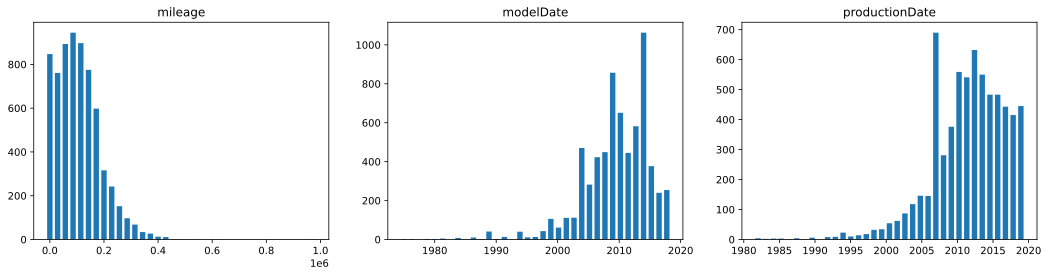

In [15]:
#посмотрим, как выглядят распределения числовых признаков
def visualize_distributions(titles_values_dict):
  columns = min(3, len(titles_values_dict))
  rows = (len(titles_values_dict) - 1) // columns + 1
  fig = plt.figure(figsize = (columns * 6, rows * 4))
  for i, (title, values) in enumerate(titles_values_dict.items()):
    hist, bins = np.histogram(values, bins = 35)
    ax = fig.add_subplot(rows, columns, i + 1)
    ax.bar(bins[:-1], hist, width = (bins[1] - bins[0]) * 0.7)
    ax.set_title(title)
  plt.show()

visualize_distributions({
    'mileage': train['mileage'].dropna(),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': train['productionDate'].dropna()
})

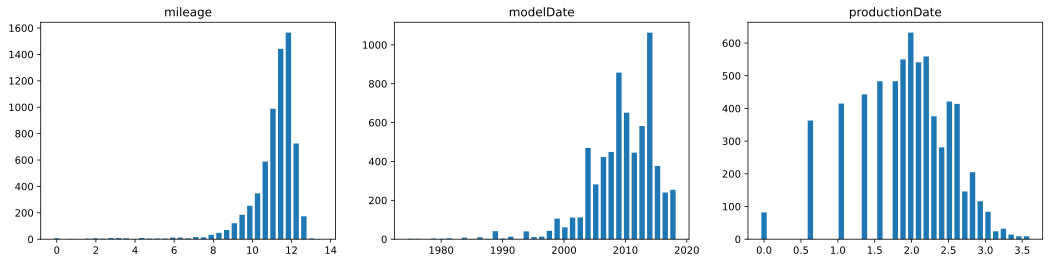

In [16]:
visualize_distributions({'mileage': np.log(train['mileage'].dropna()),
    'modelDate': train['modelDate'].dropna(),
    'productionDate': np.log(2021-train['productionDate'].dropna())
})

Итого:
* CatBoost сможет работать с признаками и в таком виде, но для нейросети нужны нормированные данные.
* Парочку признаков можно прологарифмировать

# PreProc Tabular Data

In [17]:
# используем все текстовые признаки как категориальные без предобработки
categorical_features = ['bodyType', 'brand', 'color', 'fuelType', 'model_info', 'vehicleTransmission', 'Владельцы', 'ПТС', 'Привод', 'Руль']

# используем все числовые признаки
numerical_features = ['mileage', 'modelDate', 'productionDate','engineDisplacement','enginePower',
  'numberOfDoors']

In [18]:
# ВАЖНО! дря корректной обработки признаков объединяем трейн и тест в один датасет
train['sample'] = 1 # помечаем где у нас трейн
test['sample'] = 0 # помечаем где у нас тест
test['price'] = 0 # в тесте у нас нет значения price, мы его должны предсказать, поэтому пока просто заполняем нулями

data = test.append(train, sort=False).reset_index(drop=True) # объединяем
print(train.shape, test.shape, data.shape)

(6682, 23) (1671, 23) (8353, 23)


In [19]:
def preproc_data(df_input):
    """includes several functions to pre-process the predictor data."""
    
    def engine_clean(s):
        if s.startswith('undefined'):
            return 0 #undefined LTR -> электромобиль
        
        s = re.sub('LTR','',s)
        s = re.sub('N12','',s)
        s = float(s)
        return s
        
    
    df_output = df_input.copy()
    
    # ################### 1. Предобработка ############################################################## 
    # убираем не нужные для модели признаки
    df_output.drop(['description','sell_id','name','Владение'], axis = 1, inplace=True)
    
    df_output['engineDisplacement'] = df_output['engineDisplacement'].apply(engine_clean)
    df_output['enginePower'] = df_output['enginePower'].apply(engine_clean)
    # ################### Numerical Features ############################################################## 
    # Далее заполняем пропуски
    for column in numerical_features:
        df_output[column].fillna(df_output[column].median(), inplace=True)

    # создаем новую фичу
    df_output['mil_per_year'] = df_output['mileage']/(2021-df_output['productionDate'])
    
    # Нормализация данных
    # логарифмируем mileage, enginePower и productionDate
    df_output['mileage'] = np.log(df_output['mileage'] + 1)
    df_output['enginePower'] = np.log(df_output['enginePower'] + 1)
    df_output['productionDate'] = np.log(2021-df_output['productionDate'])
        
    scaler = MinMaxScaler()
    for column in numerical_features + ['mil_per_year']:
        df_output[column] = scaler.fit_transform(df_output[[column]])[:,0]
    
    
    
    # ################### Categorical Features ############################################################## 
    # Label Encoding
    for column in categorical_features:
        df_output[column] = df_output[column].astype('category').cat.codes
        
    # One-Hot Encoding: в pandas есть готовая функция - get_dummies.
    df_output = pd.get_dummies(df_output, columns=categorical_features, dummy_na=False)
    # тут ваш код не Encoding фитчей
    # ....
    
    
    # ################### Feature Engineering ####################################################
    # тут ваш код не генерацию новых фитчей
    # ....
    
    
    # ################### Clean #################################################### 
    # убираем признаки которые еще не успели обработать, 
    df_output.drop(['vehicleConfiguration'], axis = 1, inplace=True)
    
    return df_output

In [20]:
# Запускаем и проверяем, что получилось
df_preproc = preproc_data(data)
df_preproc.sample(10)

,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,sample,price,mil_per_year,bodyType_0,...,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
7399,0.303030,0.528676,0.829686,0.895833,1.000000,0.489076,1,1590000.0,0.231830,0,...,1,0,0,0,1,0,0,1,1,0
4273,0.303030,0.528676,0.763680,0.875000,1.000000,0.439310,1,3100000.0,0.116996,0,...,1,0,0,0,1,0,0,1,1,0
3362,0.833333,0.919349,0.778972,0.875000,0.666667,0.489076,1,3750000.0,0.119163,0,...,0,0,1,0,1,0,0,1,1,0
2794,0.454545,0.528676,0.841535,0.833333,0.666667,0.628510,1,1990000.0,0.162497,0,...,0,0,1,0,1,0,0,1,1,0
5378,0.303030,0.476348,0.854919,0.875000,0.666667,0.489076,1,1285000.0,0.322831,0,...,0,0,1,0,1,0,0,1,1,0
5902,0.606061,0.899726,0.797132,0.854167,1.000000,0.567601,1,3399999.0,0.113421,0,...,1,0,0,0,1,0,0,1,1,0
1454,0.454545,0.648449,0.775812,0.854167,0.666667,0.489076,0,0.0,0.114323,0,...,0,1,0,0,1,0,0,1,1,0
2476,0.378788,0.476348,0.866520,0.750000,0.666667,0.700125,1,700000.0,0.173497,0,...,0,0,1,1,0,1,0,0,1,0
743,0.242424,0.190324,0.838424,0.750000,1.000000,0.654526,0,0.0,0.141815,0,...,0,0,1,0,1,1,0,0,1,0
1168,0.833333,0.886702,0.746676,0.854167,1.000000,0.531153,0,0.0,0.066853,0,...,0,0,1,0,1,0,0,1,1,0


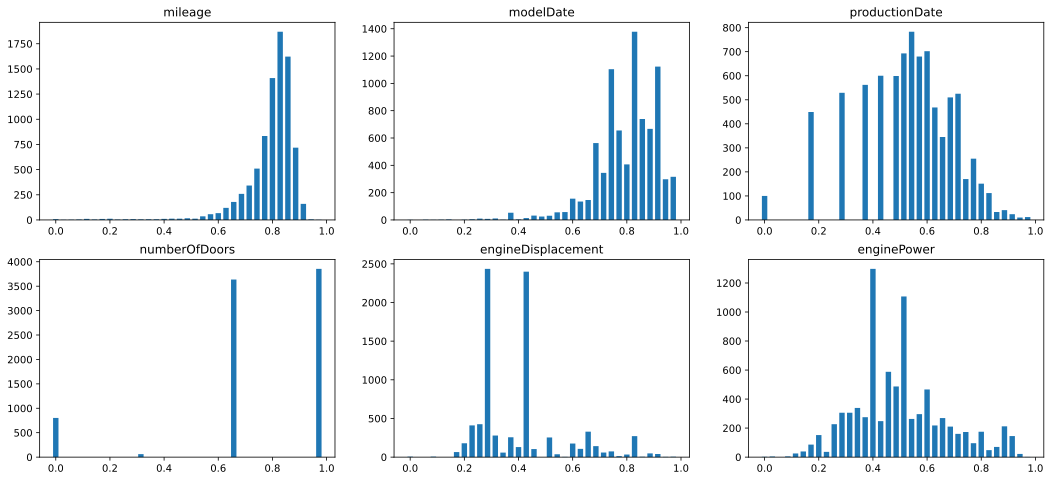

In [21]:
visualize_distributions({
    'mileage': df_preproc['mileage'],
    'modelDate': df_preproc['modelDate'],
    'productionDate': df_preproc['productionDate'],
    'numberOfDoors': df_preproc['numberOfDoors'],
    'engineDisplacement': df_preproc['engineDisplacement'],
    'enginePower': df_preproc['enginePower'],
})

In [22]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8353 entries, 0 to 8352
Columns: 186 entries, engineDisplacement to Руль_1
dtypes: float64(8), int64(1), uint8(177)
memory usage: 2.0 MB


## Split data

In [23]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.price.values     # наш таргет
X = train_data.drop(['price'], axis=1)
X_sub = test_data.drop(['price'], axis=1)

In [24]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1671 entries, 0 to 1670
Columns: 185 entries, engineDisplacement to Руль_1
dtypes: float64(8), uint8(177)
memory usage: 406.3 KB


# Model 2: CatBoostRegressor

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, shuffle=True, random_state=RANDOM_SEED)

In [26]:
model = CatBoostRegressor(iterations = 6000,
                          depth=5,
                          learning_rate = 0.15,
                          random_seed = RANDOM_SEED,
                          eval_metric='MAPE',
                          custom_metric=['RMSE', 'MAE'],
                          od_wait=500,
                          #task_type='GPU',
                         )
model.fit(X_train, y_train,
         eval_set=(X_test, y_test),
         verbose_eval=100,
         use_best_model=True,
         plot=True
         )

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.8858782	test: 0.9066907	best: 0.9066907 (0)	total: 52.9ms	remaining: 5m 17s
100:	learn: 0.1696961	test: 0.1667177	best: 0.1667177 (100)	total: 276ms	remaining: 16.1s
200:	learn: 0.1404514	test: 0.1444048	best: 0.1444048 (200)	total: 501ms	remaining: 14.4s
300:	learn: 0.1280423	test: 0.1368917	best: 0.1366758 (287)	total: 726ms	remaining: 13.7s
400:	learn: 0.1196166	test: 0.1325393	best: 0.1325289 (399)	total: 955ms	remaining: 13.3s
500:	learn: 0.1127141	test: 0.1301329	best: 0.1300699 (498)	total: 1.21s	remaining: 13.3s
600:	learn: 0.1076656	test: 0.1285074	best: 0.1284852 (596)	total: 1.47s	remaining: 13.2s
700:	learn: 0.1037224	test: 0.1270663	best: 0.1270663 (700)	total: 1.69s	remaining: 12.8s
800:	learn: 0.0999757	test: 0.1259752	best: 0.1259463 (794)	total: 1.93s	remaining: 12.5s
900:	learn: 0.0968799	test: 0.1256234	best: 0.1253437 (876)	total: 2.21s	remaining: 12.5s
1000:	learn: 0.0936469	test: 0.1247999	best: 0.1247175 (975)	total: 2.44s	remaining: 12.2s
1100:	learn

In [27]:
test_predict_catboost = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_catboost))*100:0.2f}%")

TEST mape: 12.41%


In [28]:
model.get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'MAPE',
 'iterations': 6000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'od_pval': 0,
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': True,
 'model_size_reg': 0.5,
 'subsample': 0.800000011920929,
 'use_best_model': True,
 'od_wait': 500,
 'random_seed': 42,
 'depth': 5,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'custom_metric': ['RMSE', 'MAE'],
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'RMSE',
 'learning_rate': 0.15000000596046448,
 'score_function': 'Cosine',
 'task_type': 'CPU',
 'leaf_estimat

### Submission

In [29]:
sub_predict_catboost = model.predict(X_sub)
sample_submission['price'] = sub_predict_catboost
sample_submission.to_csv('catboost_submission.csv', index=False)

# Model 3: Tabular NN

Построим обычную сеть:

In [30]:
X_train.head(5)

,engineDisplacement,enginePower,mileage,modelDate,numberOfDoors,productionDate,mil_per_year,bodyType_0,bodyType_1,bodyType_2,...,Владельцы_0,Владельцы_1,Владельцы_2,ПТС_0,ПТС_1,Привод_0,Привод_1,Привод_2,Руль_0,Руль_1
7320,0.909091,0.886702,0.855429,0.770833,0.666667,0.628510,0.194997,0,0,0,...,1,0,0,0,1,1,0,0,1,0
8037,0.303030,0.528676,0.705392,0.937500,1.000000,0.299875,0.090745,0,1,0,...,1,0,0,0,1,0,0,1,1,0
4681,0.469697,0.546610,0.846775,0.687500,0.666667,0.739185,0.116040,0,0,0,...,0,0,1,0,1,0,0,1,1,0
6014,0.272727,0.400411,0.915514,0.729167,0.666667,0.720353,0.306426,0,0,0,...,0,0,1,0,1,1,0,0,1,0
3649,0.454545,0.638525,0.842142,0.833333,0.666667,0.567601,0.204747,0,0,0,...,1,0,0,0,1,0,0,1,1,0


## Simple Dense NN

In [31]:
model = Sequential()
model.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(256, activation="relu"))
model.add(L.Dropout(0.5))
model.add(L.Dense(128, activation = 'relu'))
model.add(L.Dropout(0.5))
model.add(L.Dense(1, activation="linear"))

In [32]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               94720     
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 1

In [33]:
# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=optimizers.schedules.ExponentialDecay(0.01, decay_steps = 500, decay_rate = 0.95))
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [34]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5' , monitor=['val_MAPE'], verbose=0  , mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=50, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

### Fit

In [35]:
history = model.fit(X_train, y_train,
                    batch_size=512,
                    epochs=600, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=(X_test, y_test),
                    callbacks=callbacks_list,
                    #verbose=1,
                   )

Epoch 1/600
12/12 [==============================] - 0s 19ms/step - loss: 99.9658 - MAPE: 99.9658 - val_loss: 99.5763 - val_MAPE: 99.5763
Epoch 2/600
12/12 [==============================] - 0s 6ms/step - loss: 96.3140 - MAPE: 96.3140 - val_loss: 82.9219 - val_MAPE: 82.9219
Epoch 3/600
12/12 [==============================] - 0s 7ms/step - loss: 62.1167 - MAPE: 62.1167 - val_loss: 56.8781 - val_MAPE: 56.8781
Epoch 4/600
12/12 [==============================] - 0s 6ms/step - loss: 51.0497 - MAPE: 51.0497 - val_loss: 48.8545 - val_MAPE: 48.8545
Epoch 5/600
12/12 [==============================] - 0s 6ms/step - loss: 46.8880 - MAPE: 46.8880 - val_loss: 44.0896 - val_MAPE: 44.0896
Epoch 6/600
12/12 [==============================] - 0s 6ms/step - loss: 43.8276 - MAPE: 43.8276 - val_loss: 41.2024 - val_MAPE: 41.2024
Epoch 7/600
12/12 [==============================] - 0s 6ms/step - loss: 41.4722 - MAPE: 41.4722 - val_loss: 38.5460 - val_MAPE: 38.5460
Epoch 8/600
12/12 [=====================

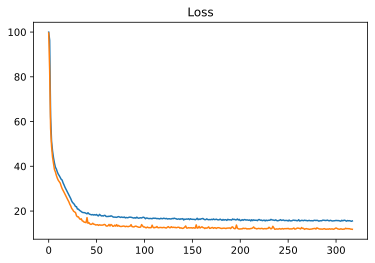

In [36]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [37]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_1.hdf5')

In [38]:
test_predict_nn1 = model.predict(X_test)
print(f"TEST mape: {(mape(y_test, test_predict_nn1[:,0]))*100:0.2f}%")

TEST mape: 11.85%


In [39]:
sub_predict_nn1 = model.predict(X_sub)
sample_submission['price'] = sub_predict_nn1[:,0]
sample_submission.to_csv('nn1_submission.csv', index=False)

# Model 4: NLP + Multiple Inputs

In [40]:
data.description

0       Всем привет!\n\nПродам эксклюзивный проект 124...
1       Продаю любимейшую тачилу.. Обвес и тюнинг Hamm...
2       Машина тут продаётся не в первый раз, НО! Толь...
3       Автомобиль в отличном состоянии, весь в родной...
4       Немка! с бесключивым доступом и камерой заднег...
                              ...                        
8348    Продаётся любимый автомобиль! За годы эксплуат...
8349    Куплена у официального дилера в 2017 г. \n\nТр...
8350    Торг на месте. Все работает. Сборка немецкая. ...
8351    Автомобиль в отличном состоянии.\n3-из Авто в ...
8352    Удлиненный заводской Pullman на базе W140 (воо...
Name: description, Length: 8353, dtype: object

In [41]:
# Определим функцию лемматизации
morph = pymorphy2.MorphAnalyzer()
df_NLP = data.copy()

patterns = "[A-Za-z0-9!#$%&'()*+,./:;<=>?@[\]^_`{|}~—\"\-]+"

def lemmatize(doc):
    doc = re.sub(patterns, ' ', doc)
    tokens = []
    for token in doc.split():
        token = token.strip()
        token = morph.normal_forms(token)[0]
        tokens.append(token)
    return ' '.join(tokens)

In [42]:
# Применяем лемматизацию
df_NLP['description'] = df_NLP.apply(
    lambda df_NLP: lemmatize(df_NLP.description), axis=1)

In [43]:
# TOKENIZER
# The maximum number of words to be used. (most frequent)
MAX_WORDS = 100000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 256

In [44]:
# split данных
text_train = data.description.iloc[X_train.index]
text_test = data.description.iloc[X_test.index]
text_sub = data.description.iloc[X_sub.index]

### Tokenizer

In [45]:
%%time
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

CPU times: user 1.63 s, sys: 9.84 ms, total: 1.64 s
Wall time: 1.65 s


In [46]:
tokenize.word_index

{'•': 1,
 'в': 2,
 'и': 3,
 'с': 4,
 'на': 5,
 'не': 6,
 'по': 7,
 'система': 8,
 'автомобиль': 9,
 'все': 10,
 'для': 11,
 'автомобиля': 12,
 'от': 13,
 'до': 14,
 'при': 15,
 'у': 16,
 'пробегом': 17,
 '2': 18,
 'состоянии': 19,
 'без': 20,
 'авто': 21,
 'салон': 22,
 'пакет': 23,
 'за': 24,
 'машина': 25,
 'автомобилей': 26,
 'сидений': 27,
 'птс': 28,
 'безопасности': 29,
 'то': 30,
 'bmw': 31,
 'из': 32,
 'более': 33,
 '000': 34,
 'автомобили': 35,
 'водителя': 36,
 'комплектация': 37,
 'есть': 38,
 '1': 39,
 'года': 40,
 'комплект': 41,
 'сиденья': 42,
 'только': 43,
 'дилера': 44,
 'салона': 45,
 'пробег': 46,
 'контроль': 47,
 'фары': 48,
 '6': 49,
 'диски': 50,
 'кредит': 51,
 'лет': 52,
 'передние': 53,
 '3': 54,
 'руля': 55,
 'датчик': 56,
 'пассажира': 57,
 'км': 58,
 'оригинал': 59,
 'подушки': 60,
 'а': 61,
 'мы': 62,
 '9': 63,
 'подогрев': 64,
 'заднего': 65,
 'состояние': 66,
 'вас': 67,
 '5': 68,
 'обслуживание': 69,
 'зеркал': 70,
 '–': 71,
 'торг': 72,
 'дтп': 73,
 '

In [47]:
%%time
text_train_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_train), maxlen=MAX_SEQUENCE_LENGTH)
text_test_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_test), maxlen=MAX_SEQUENCE_LENGTH)
text_sub_sequences = sequence.pad_sequences(tokenize.texts_to_sequences(text_sub), maxlen=MAX_SEQUENCE_LENGTH)

print(text_train_sequences.shape, text_test_sequences.shape, text_sub_sequences.shape, )

(5679, 256) (1003, 256) (1671, 256)
CPU times: user 1.39 s, sys: 3.9 ms, total: 1.39 s
Wall time: 1.39 s


In [48]:
# вот так теперь выглядит наш текст
print(text_train.iloc[6])
print(text_train_sequences[6])

.

• Автомобиль проверен по 110 пунктам
• Автокредит по специальной ставке от 13,7%

Ауди Центр Север, официальный дилер Audi, входящий в группу компаний РОЛЬФ и являющийся одним из крупнейших дилеров в Европе, предлагает Вам ряд услуг по покупке и продаже автомобилей с пробегом.

На протяжении многих лет наш дилерский центр является лидером по продаже автомобилей с пробегом среди всех дилеров Audi в России и предоставляет клиентам самый большой выбор автомобилей с пробегом Audi и других марок.
Каждый автомобиль проходит тщательную диагностику и подготовку, и гарантировано находится в отличном состоянии.
Чтобы убедиться в правильном выборе, у Вас есть возможность пройти тест-драйв ― ознакомительную поездку на интересующем автомобиле.
Вы сможете ознакомиться с автомобилем не выходя из дома – наш менеджер проведет online презентацию и в видеозвонке покажет выбранный автомобиль.
Также Ауди Центр Север представляет уникальное предложение по кредитованию автомобилей с пробегом на индивидуал

### RNN NLP

In [49]:
model_nlp = Sequential()
model_nlp.add(L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"))
model_nlp.add(L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,))
model_nlp.add(L.LSTM(256, return_sequences=True))
model_nlp.add(L.Dropout(0.5))
model_nlp.add(L.LSTM(128,))
model_nlp.add(L.Dropout(0.25))
model_nlp.add(L.Dense(64, activation="relu"))
model_nlp.add(L.Dropout(0.25))

### MLP

In [50]:
model_mlp = Sequential()
model_mlp.add(L.Dense(512, input_dim=X_train.shape[1], activation="relu"))
model_mlp.add(L.Dropout(0.5))
model_mlp.add(L.Dense(256, activation="relu"))
model_mlp.add(L.Dropout(0.5))

### Multiple Inputs NN

In [51]:
combinedInput = L.concatenate([model_nlp.output, model_mlp.output])
# being our regression head
head = L.Dense(64, activation="relu")(combinedInput)
head = L.Dense(1, activation="linear")(head)

model = Model(inputs=[model_nlp.input, model_mlp.input], outputs=head)

In [52]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
seq_description (InputLayer)    [(None, 256)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 256, 256)     10135552    seq_description[0][0]            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 256, 256)     525312      embedding[0][0]                  
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, 256, 256)     0           lstm[0][0]                       
_______________________________________________________________________________________

### Fit

In [53]:
optimizer = tf.keras.optimizers.Adam(learning_rate=optimizers.schedules.ExponentialDecay(0.01, decay_steps = 500, decay_rate = 0.95))
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [54]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [55]:
history = model.fit([text_train_sequences, X_train], y_train,
                    batch_size=512,
                    epochs=500, # фактически мы обучаем пока EarlyStopping не остановит обучение
                    validation_data=([text_test_sequences, X_test], y_test),
                    callbacks=callbacks_list
                   )

Epoch 1/500
12/12 [==============================] - 5s 421ms/step - loss: 99.9802 - MAPE: 99.9802 - val_loss: 99.7769 - val_MAPE: 99.7769
Epoch 2/500
12/12 [==============================] - 5s 384ms/step - loss: 98.1406 - MAPE: 98.1406 - val_loss: 91.8735 - val_MAPE: 91.8735
Epoch 3/500
12/12 [==============================] - 4s 360ms/step - loss: 75.0506 - MAPE: 75.0506 - val_loss: 49.6219 - val_MAPE: 49.6219
Epoch 4/500
12/12 [==============================] - 4s 356ms/step - loss: 52.4519 - MAPE: 52.4519 - val_loss: 47.4804 - val_MAPE: 47.4804
Epoch 5/500
12/12 [==============================] - 4s 363ms/step - loss: 47.4518 - MAPE: 47.4518 - val_loss: 45.0715 - val_MAPE: 45.0715
Epoch 6/500
12/12 [==============================] - 5s 386ms/step - loss: 44.3458 - MAPE: 44.3458 - val_loss: 42.4183 - val_MAPE: 42.4183
Epoch 7/500
12/12 [==============================] - 4s 361ms/step - loss: 42.0622 - MAPE: 42.0622 - val_loss: 39.9136 - val_MAPE: 39.9136
Epoch 8/500
12/12 [========

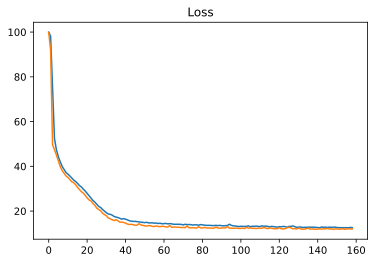

In [56]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

In [57]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_mlp_nlp.hdf5')

In [58]:
test_predict_nn2 = model.predict([text_test_sequences, X_test])
print(f"TEST mape: {(mape(y_test, test_predict_nn2[:,0]))*100:0.2f}%")

TEST mape: 12.06%


In [59]:
sub_predict_nn2 = model.predict([text_sub_sequences, X_sub])
sample_submission['price'] = sub_predict_nn2[:,0]
sample_submission.to_csv('nn2_submission.csv', index=False)

# Model 5: Добавляем картинки

### Data

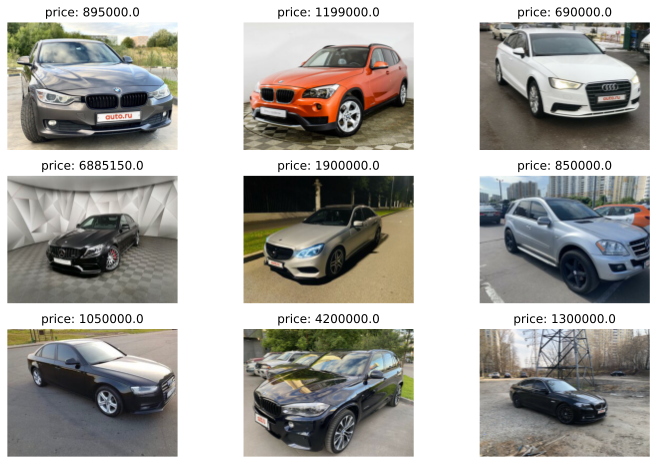

In [60]:
# убедимся, что цены и фото подгрузились верно
plt.figure(figsize = (12,8))

random_image = train.sample(n = 9)
random_image_paths = random_image['sell_id'].values
random_image_cat = random_image['price'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(DATA_DIR+'img/img/' + str(path) + '.jpg')
    plt.subplot(3, 3, index + 1)
    plt.imshow(im)
    plt.title('price: ' + str(random_image_cat[index]))
    plt.axis('off')
plt.show()

In [61]:
size = (320, 240)

def get_image_array(index):
    images_train = []
    for index, sell_id in enumerate(data['sell_id'].iloc[index].values):
        image = cv2.imread(DATA_DIR + 'img/img/' + str(sell_id) + '.jpg')
        assert(image is not None)
        image = cv2.resize(image, size)
        images_train.append(image)
    images_train = np.array(images_train)
    print('images shape', images_train.shape, 'dtype', images_train.dtype)
    return(images_train)

images_train = get_image_array(X_train.index)
images_test = get_image_array(X_test.index)
images_sub = get_image_array(X_sub.index)

images shape (5679, 240, 320, 3) dtype uint8
images shape (1003, 240, 320, 3) dtype uint8
images shape (1671, 240, 320, 3) dtype uint8


### albumentations

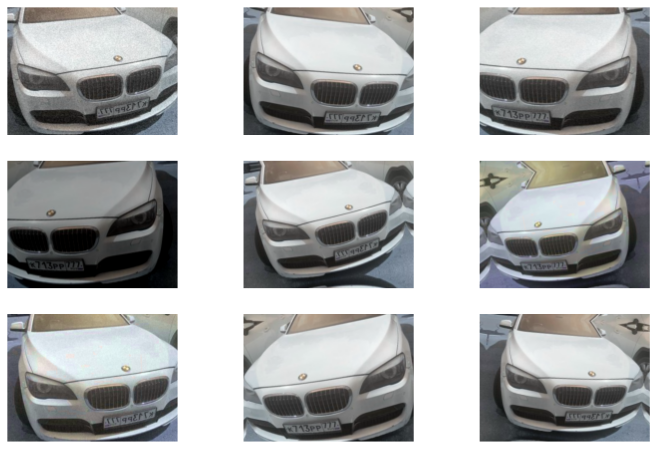

In [62]:
from albumentations import (
    HorizontalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose
)


#пример взят из официальной документации: https://albumentations.readthedocs.io/en/latest/examples.html
augmentation = Compose([
    HorizontalFlip(),
    OneOf([
        IAAAdditiveGaussianNoise(),
        GaussNoise(),
    ], p=0.2),
    OneOf([
        MotionBlur(p=0.2),
        MedianBlur(blur_limit=3, p=0.1),
        Blur(blur_limit=3, p=0.1),
    ], p=0.2),
    ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=15, p=1),
    OneOf([
        OpticalDistortion(p=0.3),
        GridDistortion(p=0.1),
        IAAPiecewiseAffine(p=0.3),
    ], p=0.2),
    OneOf([
        CLAHE(clip_limit=2),
        IAASharpen(),
        IAAEmboss(),
        RandomBrightnessContrast(),
    ], p=0.3),
    HueSaturationValue(p=0.3),
], p=1)

#пример
plt.figure(figsize = (12,8))
for i in range(9):
    img = augmentation(image = images_train[0])['image']
    plt.subplot(3, 3, i + 1)
    plt.imshow(img)
    plt.axis('off')
plt.show()

In [63]:
def make_augmentations(images):
  print('применение аугментаций', end = '')
  augmented_images = np.empty(images.shape)
  for i in range(images.shape[0]):
    if i % 200 == 0:
      print('.', end = '')
    augment_dict = augmentation(image = images[i])
    augmented_image = augment_dict['image']
    augmented_images[i] = augmented_image
  print('')
  return augmented_images

## tf.data.Dataset
Если все изображения мы будем хранить в памяти, то может возникнуть проблема ее нехватки. Не храните все изображения в памяти целиком!

Метод .fit() модели keras может принимать либо данные в виде массивов или тензоров, либо разного рода итераторы, из которых наиболее современным и гибким является [tf.data.Dataset](https://www.tensorflow.org/guide/data). Он представляет собой конвейер, то есть мы указываем, откуда берем данные и какую цепочку преобразований с ними выполняем. Далее мы будем работать с tf.data.Dataset.

Dataset хранит информацию о конечном или бесконечном наборе кортежей (tuple) с данными и может возвращать эти наборы по очереди. Например, данными могут быть пары (input, target) для обучения нейросети. С данными можно осуществлять преобразования, которые осуществляются по мере необходимости ([lazy evaluation](https://ru.wikipedia.org/wiki/%D0%9B%D0%B5%D0%BD%D0%B8%D0%B2%D1%8B%D0%B5_%D0%B2%D1%8B%D1%87%D0%B8%D1%81%D0%BB%D0%B5%D0%BD%D0%B8%D1%8F)).

`tf.data.Dataset.from_tensor_slices(data)` - создает датасет из данных, которые представляют собой либо массив, либо кортеж из массивов. Деление осуществляется по первому индексу каждого массива. Например, если `data = (np.zeros((128, 256, 256)), np.zeros(128))`, то датасет будет содержать 128 элементов, каждый из которых содержит один массив 256x256 и одно число.

`dataset2 = dataset1.map(func)` - применение функции к датасету; функция должна принимать столько аргументов, каков размер кортежа в датасете 1 и возвращать столько, сколько нужно иметь в датасете 2. Пусть, например, датасет содержит изображения и метки, а нам нужно создать датасет только из изображений, тогда мы напишем так: `dataset2 = dataset.map(lambda img, label: img)`.

`dataset2 = dataset1.batch(8)` - группировка по батчам; если датасет 2 должен вернуть один элемент, то он берет из датасета 1 восемь элементов, склеивает их (нулевой индекс результата - номер элемента) и возвращает.

`dataset.__iter__()` - превращение датасета в итератор, из которого можно получать элементы методом `.__next__()`. Итератор, в отличие от самого датасета, хранит позицию текущего элемента. Можно также перебирать датасет циклом for.

`dataset2 = dataset1.repeat(X)` - датасет 2 будет повторять датасет 1 X раз.

Если нам нужно взять из датасета 1000 элементов и использовать их как тестовые, а остальные как обучающие, то мы напишем так:

`test_dataset = dataset.take(1000)
train_dataset = dataset.skip(1000)`

Датасет по сути неизменен: такие операции, как map, batch, repeat, take, skip никак не затрагивают оригинальный датасет. Если датасет хранит элементы [1, 2, 3], то выполнив 3 раза подряд функцию dataset.take(1) мы получим 3 новых датасета, каждый из которых вернет число 1. Если же мы выполним функцию dataset.skip(1), мы получим датасет, возвращающий числа [2, 3], но исходный датасет все равно будет возвращать [1, 2, 3] каждый раз, когда мы его перебираем.

tf.Dataset всегда выполняется в graph-режиме (в противоположность eager-режиму), поэтому либо преобразования (`.map()`) должны содержать только tensorflow-функции, либо мы должны использовать tf.py_function в качестве обертки для функций, вызываемых в `.map()`. Подробнее можно прочитать [здесь](https://www.tensorflow.org/guide/data#applying_arbitrary_python_logic).

In [64]:
# NLP part
tokenize = Tokenizer(num_words=MAX_WORDS)
tokenize.fit_on_texts(data.description)

In [65]:
def process_image(image):
    return augmentation(image = image.numpy())['image']

def tokenize_(descriptions):
  return sequence.pad_sequences(tokenize.texts_to_sequences(descriptions), maxlen = MAX_SEQUENCE_LENGTH)

def tokenize_text(text):
    return tokenize_([text.numpy().decode('utf-8')])[0]

def tf_process_train_dataset_element(image, table_data, text, price):
    im_shape = image.shape
    [image,] = tf.py_function(process_image, [image], [tf.uint8])
    image.set_shape(im_shape)
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

def tf_process_val_dataset_element(image, table_data, text, price):
    [text,] = tf.py_function(tokenize_text, [text], [tf.int32])
    return (image, table_data, text), price

train_dataset = tf.data.Dataset.from_tensor_slices((
    images_train, X_train, data.description.iloc[X_train.index], y_train
    )).map(tf_process_train_dataset_element)

test_dataset = tf.data.Dataset.from_tensor_slices((
    images_test, X_test, data.description.iloc[X_test.index], y_test
    )).map(tf_process_val_dataset_element)

y_sub = np.zeros(len(X_sub))
sub_dataset = tf.data.Dataset.from_tensor_slices((
    images_sub, X_sub, data.description.iloc[X_sub.index], y_sub
    )).map(tf_process_val_dataset_element)

#проверяем, что нет ошибок (не будет выброшено исключение):
train_dataset.__iter__().__next__();
test_dataset.__iter__().__next__();
sub_dataset.__iter__().__next__();

### Строим сверточную сеть для анализа изображений без "головы"

In [66]:
#tf.keras.backend.clear_session()

In [67]:
#нормализация включена в состав модели EfficientNetB4, поэтому на вход она принимает данные типа uint8
efficientnet_model = tf.keras.applications.efficientnet.EfficientNetB4(weights = 'imagenet', include_top = False, input_shape = (size[1], size[0], 3))

efficientnet_output = L.GlobalAveragePooling2D()(efficientnet_model.output)
#Сначала просто проделываем transfer-learning
efficientnet_model.trainable=False

71688192/71686520 [==============================] - 1s 0us/step


In [68]:
#строим нейросеть для анализа табличных данных
tabular_model = Sequential([
    L.Input(shape = X.shape[1]),
    L.Dense(512, activation = 'relu'),
    L.Dropout(0.5),
    L.Dense(256, activation = 'relu'),
    L.Dropout(0.5),
    ])

In [69]:
# NLP
nlp_model = Sequential([
    L.Input(shape=MAX_SEQUENCE_LENGTH, name="seq_description"),
    L.Embedding(len(tokenize.word_index)+1, MAX_SEQUENCE_LENGTH,),
    L.LSTM(256, return_sequences=True),
    L.Dropout(0.5),
    L.LSTM(128),
    L.Dropout(0.25),
    L.Dense(64),
    ])

In [70]:
#объединяем выходы трех нейросетей
combinedInput = L.concatenate([efficientnet_output, tabular_model.output, nlp_model.output])

# being our regression head
head = L.Dense(256, activation="relu")(combinedInput)
head = L.Dense(1,)(head)

model = Model(inputs=[efficientnet_model.input, tabular_model.input, nlp_model.input], outputs=head)
model.summary()

Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 320, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 240, 320, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 240, 320, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 241, 321, 3)  0           normalization[0][0]              
_______________________________________________________________________________________

In [71]:
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fb2b1e8d410> False
<tensorflow.python.keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fb2b21901d0> False
<tensorflow.python.keras.layers.preprocessing.normalization.Normalization object at 0x7fb2b218c5d0> False
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fb2b219c650> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb2b67dc950> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb2b1e85e10> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fb2b219fb90> False
<tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7fb2b1e855d0> False
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb2b1e9fcd0> False
<tensorflow.python.keras.layers.core.Activation object at 0x7fb2b2191150> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D objec

In [72]:
optimizer = tf.keras.optimizers.Adam(learning_rate=optimizers.schedules.ExponentialDecay(0.01, decay_steps = 500, decay_rate = 0.95))
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [73]:
checkpoint = ModelCheckpoint('../working/best_model.hdf5', monitor=['val_MAPE'], verbose=0, mode='min')
earlystop = EarlyStopping(monitor='val_MAPE', patience=10, restore_best_weights=True,)
callbacks_list = [checkpoint, earlystop]

In [74]:
history = model.fit(train_dataset.batch(30),
                    epochs=125,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/125
190/190 [==============================] - 93s 488ms/step - loss: 48.9543 - MAPE: 48.9543 - val_loss: 36.2580 - val_MAPE: 36.2580
Epoch 2/125
190/190 [==============================] - 89s 469ms/step - loss: 31.9216 - MAPE: 31.9216 - val_loss: 25.9536 - val_MAPE: 25.9536
Epoch 3/125
190/190 [==============================] - 89s 470ms/step - loss: 25.1529 - MAPE: 25.1529 - val_loss: 20.7623 - val_MAPE: 20.7623
Epoch 4/125
190/190 [==============================] - 92s 482ms/step - loss: 20.6442 - MAPE: 20.6442 - val_loss: 16.5901 - val_MAPE: 16.5901
Epoch 5/125
190/190 [==============================] - 88s 464ms/step - loss: 18.3370 - MAPE: 18.3370 - val_loss: 15.3874 - val_MAPE: 15.3874
Epoch 6/125
190/190 [==============================] - 89s 468ms/step - loss: 17.7373 - MAPE: 17.7373 - val_loss: 14.3389 - val_MAPE: 14.3389
Epoch 7/125
190/190 [==============================] - 91s 480ms/step - loss: 16.8661 - MAPE: 16.8661 - val_loss: 14.3608 - val_MAPE: 14.3608
Epoch 

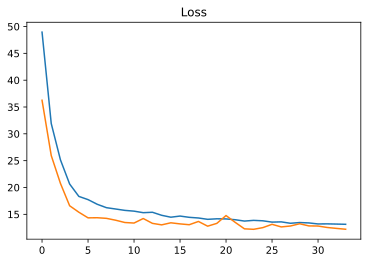

In [75]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

### Добавляем fine-tuning

In [76]:
efficientnet_model.trainable=True

for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x7fb2b1e8d410> True
<tensorflow.python.keras.layers.preprocessing.image_preprocessing.Rescaling object at 0x7fb2b21901d0> True
<tensorflow.python.keras.layers.preprocessing.normalization.Normalization object at 0x7fb2b218c5d0> True
<tensorflow.python.keras.layers.convolutional.ZeroPadding2D object at 0x7fb2b219c650> True
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x7fb2b67dc950> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb2b1e85e10> True
<tensorflow.python.keras.layers.core.Activation object at 0x7fb2b219fb90> True
<tensorflow.python.keras.layers.convolutional.DepthwiseConv2D object at 0x7fb2b1e855d0> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7fb2b1e9fcd0> True
<tensorflow.python.keras.layers.core.Activation object at 0x7fb2b2191150> True
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7fb

In [77]:
optimizer = tf.keras.optimizers.Adam(learning_rate=optimizers.schedules.ExponentialDecay(0.005, decay_steps = 400, decay_rate = 0.97))
model.compile(loss='MAPE',optimizer=optimizer, metrics=['MAPE'])

In [78]:
history = model.fit(train_dataset.batch(30),
                    epochs=150,
                    validation_data = test_dataset.batch(30),
                    callbacks=callbacks_list
                   )

Epoch 1/150
190/190 [==============================] - 175s 922ms/step - loss: 13.5565 - MAPE: 13.5565 - val_loss: 48.8638 - val_MAPE: 48.8638
Epoch 2/150
190/190 [==============================] - 174s 916ms/step - loss: 13.6257 - MAPE: 13.6257 - val_loss: 12.5903 - val_MAPE: 12.5903
Epoch 3/150
190/190 [==============================] - 174s 913ms/step - loss: 13.4321 - MAPE: 13.4321 - val_loss: 13.1012 - val_MAPE: 13.1012
Epoch 4/150
190/190 [==============================] - 173s 911ms/step - loss: 13.3108 - MAPE: 13.3108 - val_loss: 12.5821 - val_MAPE: 12.5821
Epoch 5/150
190/190 [==============================] - 173s 913ms/step - loss: 13.3079 - MAPE: 13.3079 - val_loss: 88.4452 - val_MAPE: 88.4452
Epoch 6/150
190/190 [==============================] - 172s 906ms/step - loss: 13.2668 - MAPE: 13.2668 - val_loss: 12.4544 - val_MAPE: 12.4544
Epoch 7/150
190/190 [==============================] - 173s 913ms/step - loss: 13.3635 - MAPE: 13.3635 - val_loss: 12.1874 - val_MAPE: 12.1874

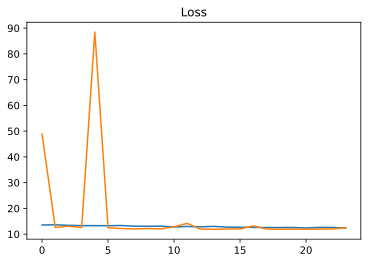

In [79]:
plt.title('Loss')
plt.plot(history.history['MAPE'], label='train')
plt.plot(history.history['val_MAPE'], label='test')
plt.show();

## Тест

In [80]:
model.load_weights('../working/best_model.hdf5')
model.save('../working/nn_final.hdf5')

In [81]:
test_predict_nn3 = model.predict(test_dataset.batch(30))
print(f"TEST mape: {(mape(y_test, test_predict_nn3[:,0]))*100:0.2f}%")

TEST mape: 12.53%


In [82]:
sub_predict_nn3 = model.predict(sub_dataset.batch(30))
sample_submission['price'] = sub_predict_nn3[:,0]
sample_submission.to_csv('nn3_submission.csv', index=False)


#### Что сделано в общем:
* Попробовано разные архитектуры
* Добавлено управление LR
* Использовано Fine-tuning

#### Tabular
* Нормализировано часть признаков логарифмированием

* Извлечено числовые значения из текста:
Парсинг признаков 'engineDisplacement', 'enginePower' для извлечения числовых значений.

* Сделано чуть-чуть Feature engineering



#### NLP
* Сделано лематизацию


#### CV
* Попробовать различные аугментации
* Fine-tuning

# Blend

In [83]:
blend_predict = (test_predict_catboost + test_predict_nn3[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 11.48%


In [84]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn3[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission1.csv', index=False)

In [85]:
blend_predict = (test_predict_catboost + test_predict_nn2[:,0]) / 2
print(f"TEST mape: {(mape(y_test, blend_predict))*100:0.2f}%")

TEST mape: 11.14%


In [86]:
blend_sub_predict = (sub_predict_catboost + sub_predict_nn2[:,0]) / 2
sample_submission['price'] = blend_sub_predict
sample_submission.to_csv('blend_submission2.csv', index=False)